# Import library

In [27]:
import rasterio
import torchgeo
import torch
import torch.nn as nn
import rioxarray
import numpy as np
import matplotlib.pyplot as plt

# Import data

In [28]:
# create image patches
class Patchify(nn.Module):
    def __init__(self, patch_size=56):
        super().__init__()
        self.p = patch_size
        self.unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x -> B c h w
        bs, c, h, w = x.shape
        
        x = self.unfold(x)
        # x -> B (c*p*p) L
        
        # Reshaping into the shape we want
        a = x.view(bs, c, self.p, self.p, -1).permute(0, 4, 1, 2, 3)
        # a -> ( B no.of patches c p p )
        return a

In [29]:
sentinel2_path = '../data/raw/sentinel-2/sentinel2_openeo_med_4months_dresden.geotiff'

In [30]:
file_path = '../data/raw/sentinel-2/sentinel2_openeo_med_4months_dresden.geotiff'
data = rioxarray.open_rasterio(file_path)
data

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

<xarray.DataArray (band: 13, y: 2301, x: 2747)> Size: 164MB
[82171011 values with dtype=int16]
Coordinates:
  * band         (band) int64 104B 1 2 3 4 5 6 7 8 9 10 11 12 13
  * x            (x) float64 22kB 4.003e+05 4.003e+05 ... 4.277e+05 4.277e+05
  * y            (y) float64 18kB 5.671e+06 5.671e+06 ... 5.648e+06 5.648e+06
    spatial_ref  int64 8B 0
Attributes:
    PROCESSING_SOFTWARE:       0.60.1a1
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        3637
    STATISTICS_MEAN:           418.7768019884
    STATISTICS_MINIMUM:        124
    STATISTICS_STDDEV:         217.06458263081
    STATISTICS_VALID_PERCENT:  97.46
    _FillValue:                -32768
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 ('B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B0...

In [31]:
# Normalize the bands to the range [0, 1]
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

In [32]:
# Apply a percentile-based contrast stretch (ignore the extreme values so image isn't too dark or too bright)
def contrast_stretch(array, lower_percentile=2, upper_percentile=98):
    lower = np.percentile(array, lower_percentile)
    upper = np.percentile(array, upper_percentile)
    array = np.clip(array, lower, upper) # clip -> limit the values in an array to specific range
    return (array - lower) / (upper - lower)

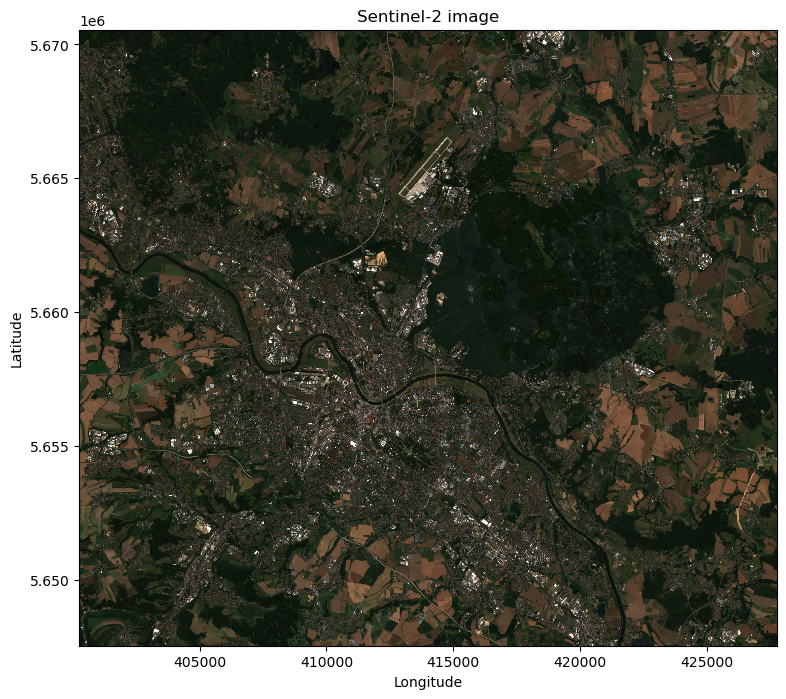

In [33]:
# Plot the raster data
plt.figure(figsize=(9,8))
# normalize(data).sel(band=[4, 3, 2]).plot.imshow()
contrast_stretch(data).sel(band=[4, 3, 2]).plot.imshow()
plt.title("Sentinel-2 image")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [43]:
import cv2

patch = Patchify()
# img_src = '../data/raw/sentinel-2/sentinel2_openeo_med_4months_dresden.geotiff'
# image = cv2.imread(img_src)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Convert DataArray to NumPy array
img = contrast_stretch(data).sel(band=[4, 3, 2]).values  # Convert xarray DataArray to NumPy

# Check if it's a multi-band image
if len(img.shape) == 3:  
    img = np.stack([img[0], img[1], img[2]], axis=-1)  # RGB bands
    # img = np.clip(img / np.max(img), 0, 1)  # Normalize

# image = img.astype('float32') / 255.0  # Normalize to [0, 1]
image = torch.from_numpy(img)
image = image.permute(2,0,1)
image = image.unsqueeze(0) #to add the batch dimension
p = patch(image)
p = p.squeeze() #to remove the batch dimension for plotting

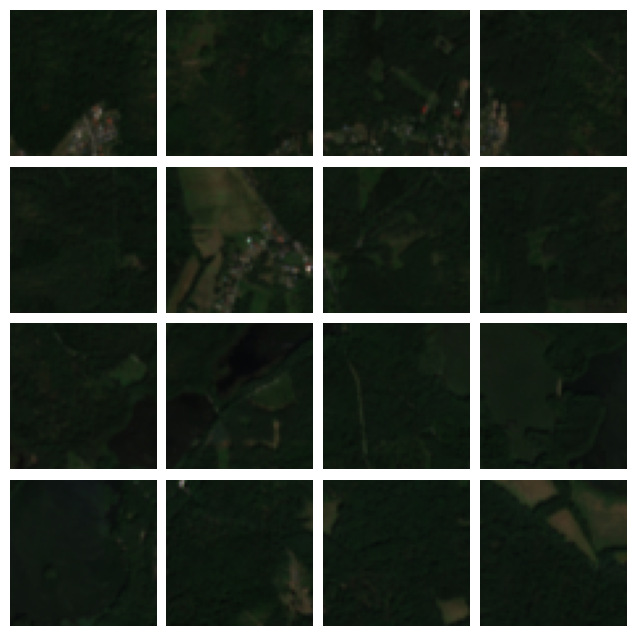

In [44]:
from mpl_toolkits.axes_grid1 import ImageGrid

def plot_patches(tensor):
    fig = plt.figure(figsize=(8, 8))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)

    for i, ax in enumerate(grid):
        patch = tensor[i].permute(1, 2, 0).numpy() 
        ax.imshow(patch)
        ax.axis('off')

    plt.show()

plot_patches(p)